# Multivariate Multi-Step LSTM Models : Multiple Input Multi-Step Output

## 데이터 준비

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
train_x_df = pd.read_csv('/content/gdrive/My Drive/open/train_x_df.csv')
train_y_df = pd.read_csv('/content/gdrive/My Drive/open/train_y_df.csv')
test_x_df = pd.read_csv('/content/gdrive/My Drive/open/test_x_df.csv')
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [3]:
train_x_df.shape

(10572180, 12)

In [4]:
import numpy as np
def df2d_to_array3d(df_2d):
    feature_size = len(df_2d.columns[2:]) # 10
    time_size = len(df_2d.time.unique()) # x는 1380, y는 120
    sample_size = len(df_2d.sample_id.unique()) # train은 7661, test는 535
    
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)

print(f'''
These shape stands for (sample_size, time_step, feature)
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
''')


These shape stands for (sample_size, time_step, feature)
train_x_array (7661, 1380, 10)
train_y_array (7661, 120, 10)



## Sample 선택

0번 샘플 선택

In [5]:
df_0 = train_x_array[0]
print('(timesteps, features)')
print(df_0.shape)

lb_0 = train_y_array[0]
print(lb_0.shape)

(timesteps, features)
(1380, 10)
(120, 10)


샘플 가공

In [6]:
in_coin_index = df_0[:,0]
in_open = df_0[:,1]
in_high = df_0[:,2]
in_low = df_0[:,3]
in_close = df_0[:,4]
in_volume = df_0[:,5]
in_quote_av = df_0[:,6]
in_trades = df_0[:,7]
in_tb_base_av = df_0[:,8]
in_tb_quote_av = df_0[:,9]

## import

In [7]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

## sample 만드는 splitter
input : 배열 , sample input 개수 , sample output 개수\
output : 학습에 쓸 train_feature (X) , 학습에 쓸 train_label (y)

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

## 학습에 쓸 데이터

In [9]:
# define input sequence # 예제
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

in data는 위에서 가공된 데이터가 있음
(in_open ~ in_tb_quote_av) 사용

out data는 close data 사용

In [10]:
out_close = lb_0[:,4]

reshape & stack

In [11]:
# convert to [rows, columns] structure
in_open = in_open.reshape((1380, 1))
in_high = in_high.reshape((1380, 1))
in_low = in_low.reshape((1380, 1))

in_close = in_close.reshape((1380, 1)) # 얘를 output으로??

in_volume = in_volume.reshape((1380, 1))
in_quote_av = in_quote_av.reshape((1380, 1))
in_trades = in_trades.reshape((1380, 1))
in_tb_base_av = in_tb_base_av.reshape((1380, 1))
in_tb_quote_av = in_tb_quote_av.reshape((1380, 1))

out_close = out_close.reshape((120, 1))

# horizontally stack columns
dataset = hstack((in_open, in_high, in_low, in_volume, in_quote_av, in_trades, in_tb_base_av, in_tb_quote_av, in_close))

in_close를 output으로 사용한다면 동일한 값을 input으로 넣으면 안 될 것 같아 input에서 뺐다

근데 이미 open, high, low가 close랑 거의 같은데 의미가 있나??

In [12]:
# choose a number of time steps
n_steps_in, n_steps_out = 225, 120

In [13]:
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

In [14]:
X.shape

(1037, 225, 8)

In [15]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

## model

LSTM의 첫번째 인자는 units 으로 은닉층의 차원을 의미 => 중소형 모델은 128, 256, ... 이런 값을 사용

In [22]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(128, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 225, 128)          70144     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               15480     
Total params: 217,208
Trainable params: 217,208
Non-trainable params: 0
_________________________________________________________________


## fit

In [33]:
# fit model
# model.fit(X, y, epochs=200, verbose=0)
model.fit(X, y_input, epochs=200, verbose=1)

Epoch 1/200
33/33 [==============================] - 14s 383ms/step - loss: nan
Epoch 2/200
33/33 [==============================] - 12s 375ms/step - loss: nan
Epoch 3/200
33/33 [==============================] - 12s 377ms/step - loss: nan
Epoch 4/200
33/33 [==============================] - 12s 378ms/step - loss: nan
Epoch 5/200
33/33 [==============================] - 13s 385ms/step - loss: nan
Epoch 6/200
33/33 [==============================] - 13s 386ms/step - loss: nan
Epoch 7/200
33/33 [==============================] - 13s 381ms/step - loss: nan
Epoch 8/200
33/33 [==============================] - 13s 385ms/step - loss: nan
Epoch 9/200
33/33 [==============================] - 13s 382ms/step - loss: nan
Epoch 10/200
33/33 [==============================] - 12s 378ms/step - loss: nan
Epoch 11/200
19/33 [================>.............] - ETA: 5s - loss: nan

KeyboardInterrupt: ignored

## predict
여기서부터 다시 작성해야 함

In [17]:
X.shape

(1037, 225, 8)

In [23]:
X_input = X[0]
X_input = X_input.reshape((1, X_input.shape[0], X_input.shape[1]))
X_input.shape

(1, 225, 8)

In [24]:
y_hat = model.predict(X_input)
y_hat.shape

(1, 120)

In [25]:
y.shape # 1037, 1 ,120 // 시작시간, feature, 시작~120까지
# np.sum(np.square(y_hat - y[0])) # 안 될 수도 있음

(1037, 120)

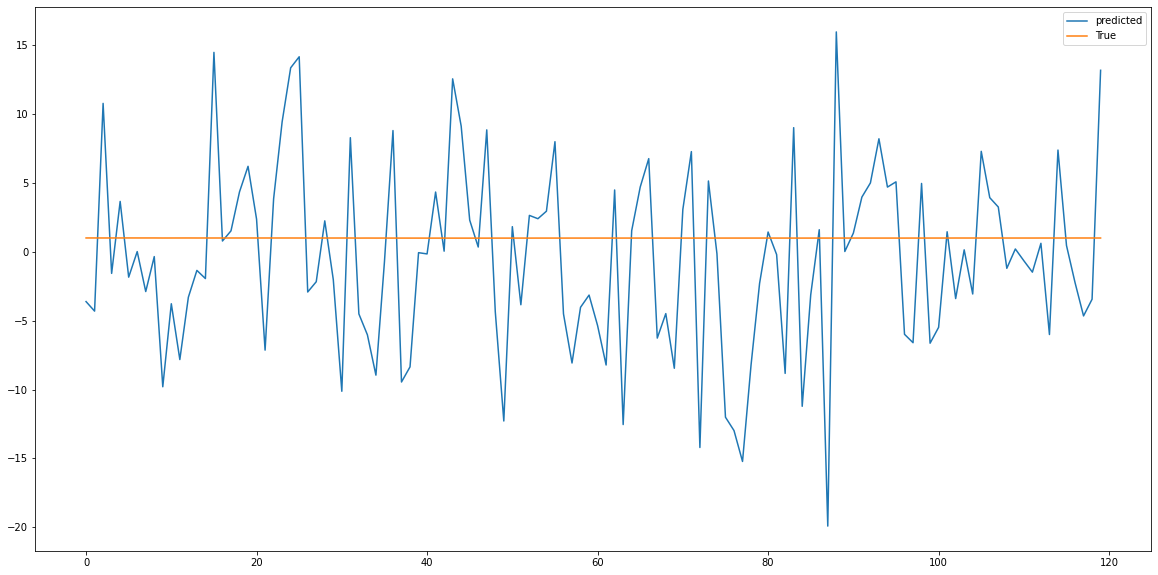

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_hat[0], label='predicted')
plt.plot(y[0], label='True')
plt.legend()

In [28]:
y[0]

array([0.99063808, 0.99064666, 0.98940623, 0.98978192, 0.99071813,
       0.99125403, 0.99088448, 0.99088448, 0.9907366 , 0.98747718,
       0.98842078, 0.9890306 , 0.98979062, 0.98817444, 0.98813748,
       0.98813623, 0.98804384, 0.9880414 , 0.98854399, 0.98878539,
       0.98792803, 0.98848236, 0.98818058, 0.98829758, 0.98791701,
       0.98669624, 0.98669624, 0.98584133, 0.9864462 , 0.98634517,
       0.98669624, 0.98657185, 0.98245996, 0.98461938, 0.98253763,
       0.98349226, 0.98187727, 0.98213965, 0.9814018 , 0.98109388,
       0.97979921, 0.98013061, 0.98053461, 0.97992116, 0.97934467,
       0.97942841, 0.97869056, 0.97898746, 0.98104954, 0.98069721,
       0.98053706, 0.98193276, 0.98114932, 0.98235404, 0.98226166,
       0.98243159, 0.98132175, 0.98275435, 0.9825092 , 0.98255605,
       0.9833678 , 0.9823848 , 0.9823848 , 0.98273343, 0.98300076,
       0.98292559, 0.98273098, 0.98292559, 0.98236018, 0.98158532,
       0.9823873 , 0.98176891, 0.98226047, 0.98239964, 0.98337

In [31]:
y_input = y.reshape((y.shape[0], 1, y.shape[1]))

In [32]:
y_input.shape

(1037, 1, 120)

In [ ]:
x_input[:225].shape

(225, 9)

In [ ]:
x_input.shape

(1380, 9)

In [ ]:
x_input = x_input.reshape((1, 1380, 9))

In [ ]:
# demonstrate prediction
# x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = dataset
x_input = x_input.reshape((1, n_steps_in, x_input.shape[1]))
yhat = model.predict(x_input, verbose=0)

ValueError: ignored

In [ ]:
yhat = model.predict(x_input, verbose=0)

ValueError: ignored

In [ ]:
yhat

시각화

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_hat[0], label='predicted')
plt.plot(y[0][0], label='True')
plt.legend()

In [ ]:
y[0]

array([0.99063808, 0.99064666, 0.98940623, 0.98978192, 0.99071813,
       0.99125403, 0.99088448, 0.99088448, 0.9907366 , 0.98747718,
       0.98842078, 0.9890306 , 0.98979062, 0.98817444, 0.98813748,
       0.98813623, 0.98804384, 0.9880414 , 0.98854399, 0.98878539,
       0.98792803, 0.98848236, 0.98818058, 0.98829758, 0.98791701,
       0.98669624, 0.98669624, 0.98584133, 0.9864462 , 0.98634517,
       0.98669624, 0.98657185, 0.98245996, 0.98461938, 0.98253763,
       0.98349226, 0.98187727, 0.98213965, 0.9814018 , 0.98109388,
       0.97979921, 0.98013061, 0.98053461, 0.97992116, 0.97934467,
       0.97942841, 0.97869056, 0.97898746, 0.98104954, 0.98069721,
       0.98053706, 0.98193276, 0.98114932, 0.98235404, 0.98226166,
       0.98243159, 0.98132175, 0.98275435, 0.9825092 , 0.98255605,
       0.9833678 , 0.9823848 , 0.9823848 , 0.98273343, 0.98300076,
       0.98292559, 0.98273098, 0.98292559, 0.98236018, 0.98158532,
       0.9823873 , 0.98176891, 0.98226047, 0.98239964, 0.98337